# Training Notebook for the RNN Approach

### Import Dependencies

In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import os
from utils import *

model_output_path = 'models'
os.makedirs(model_output_path, exist_ok=True)

In [2]:
#set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True

Seed set to 42


### Dataset & Dataloader Definition

In [3]:
df_filtered = pd.read_csv("original_training_set_filtered.csv")
df_train = pd.read_csv("splits/train.csv")
df_val = pd.read_csv("splits/val.csv")
df_test = pd.read_csv("splits/test.csv")

# Preprocessing
feature_columns = [col for col in df_train.columns if col not in ["label", "exp_name"]]
scaler = StandardScaler()
scaler.fit(df_train[feature_columns])
mean = scaler.mean_
std = scaler.scale_

# Label encoding
exp_labels = df_filtered.groupby("exp_name")["label"].first()
label_encoder = LabelEncoder()
label_encoder.fit(exp_labels.values)
exp_name_to_label = exp_labels.to_dict()

train_dataset = SensorSequenceDataset(df_train, exp_name_to_label, label_encoder, mean, std)
val_dataset   = SensorSequenceDataset(df_val,   exp_name_to_label, label_encoder, mean, std)
test_dataset  = SensorSequenceDataset(df_test,  exp_name_to_label, label_encoder, mean, std)

In [4]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 339
Validation dataset size: 41
Test dataset size: 41


In [5]:
BATCH_SIZE = 20

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_padded
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_padded
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_padded
)

### Model Training

#### GRU RNN

In [6]:
# Parametri modello
hidden_dim = 64
rnn_type = "GRU"

model = RNNClassifier(
    input_dim=len(feature_columns),
    hidden_dim=hidden_dim,
    output_dim=len(label_encoder.classes_),
    rnn_type=rnn_type,
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [16]:
# Training setup
MAX_EPOCHS = 1000

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    log_every_n_steps=10
)

# Addestramento
trainer.fit(model, train_loader, val_loader)

# Salvataggio modello
output_name = f"RNN_{rnn_type}_h{hidden_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | rnn     | GRU              | 15.7 K | train
1 | dropout | Dropout          | 0      | train
2 | fc      | Linear           | 1.1 K  | train
3 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
16.8 K    Trainable params
0         Non-trainable params
16.8 K    Total params
0.067     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 999: 100%|██████████| 17/17 [00:09<00:00,  1.72it/s, v_num=0, train_loss=0.915, train_acc=0.684, val_loss=1.120, val_acc=0.537]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 17/17 [00:09<00:00,  1.71it/s, v_num=0, train_loss=0.915, train_acc=0.684, val_loss=1.120, val_acc=0.537]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 17/17 [00:02<00:00,  6.51it/s]

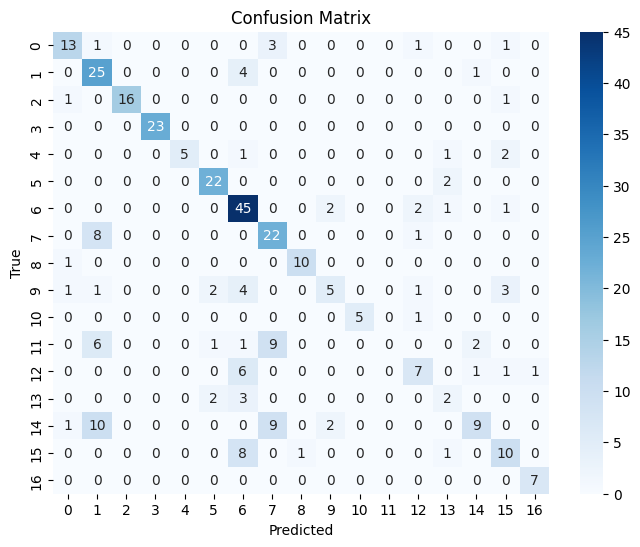

Testing DataLoader 0: 100%|██████████| 17/17 [00:03<00:00,  4.96it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     final_test_acc         0.6666666865348816
        test_acc            0.6666666865348816
        test_loss           0.9503999352455139
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 13.19it/s]

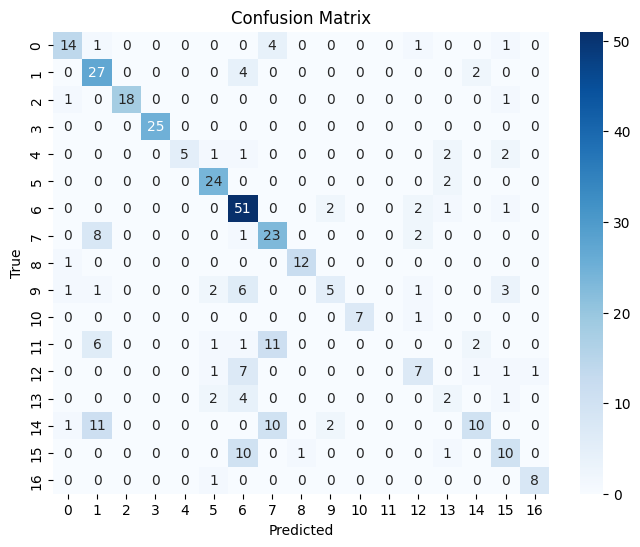

Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     final_test_acc         0.6526315808296204
        test_acc            0.5365853905677795
        test_loss           1.1230229139328003
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  6.88it/s]

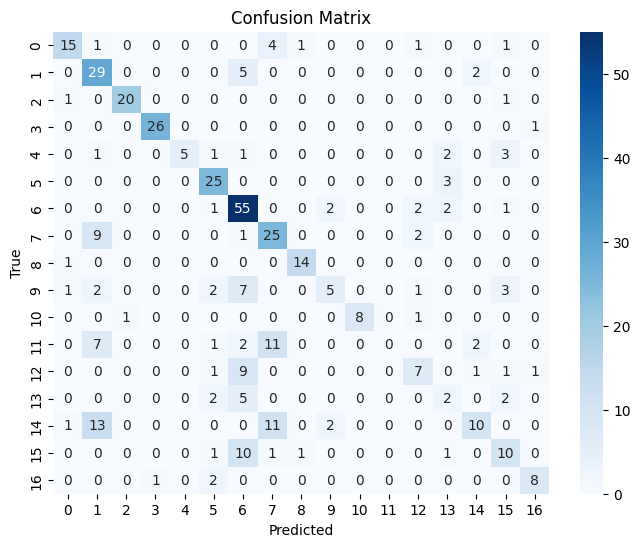

Testing DataLoader 0: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     final_test_acc         0.6270784139633179
        test_acc            0.39024388790130615
        test_loss           1.5425658226013184
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5425658226013184,
  'test_acc': 0.39024388790130615,
  'final_test_acc': 0.6270784139633179}]

In [8]:
# Load the model for testing (from checkpoint)
model = RNNClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, train_loader)
trainer.test(model, val_loader)
trainer.test(model, test_loader)

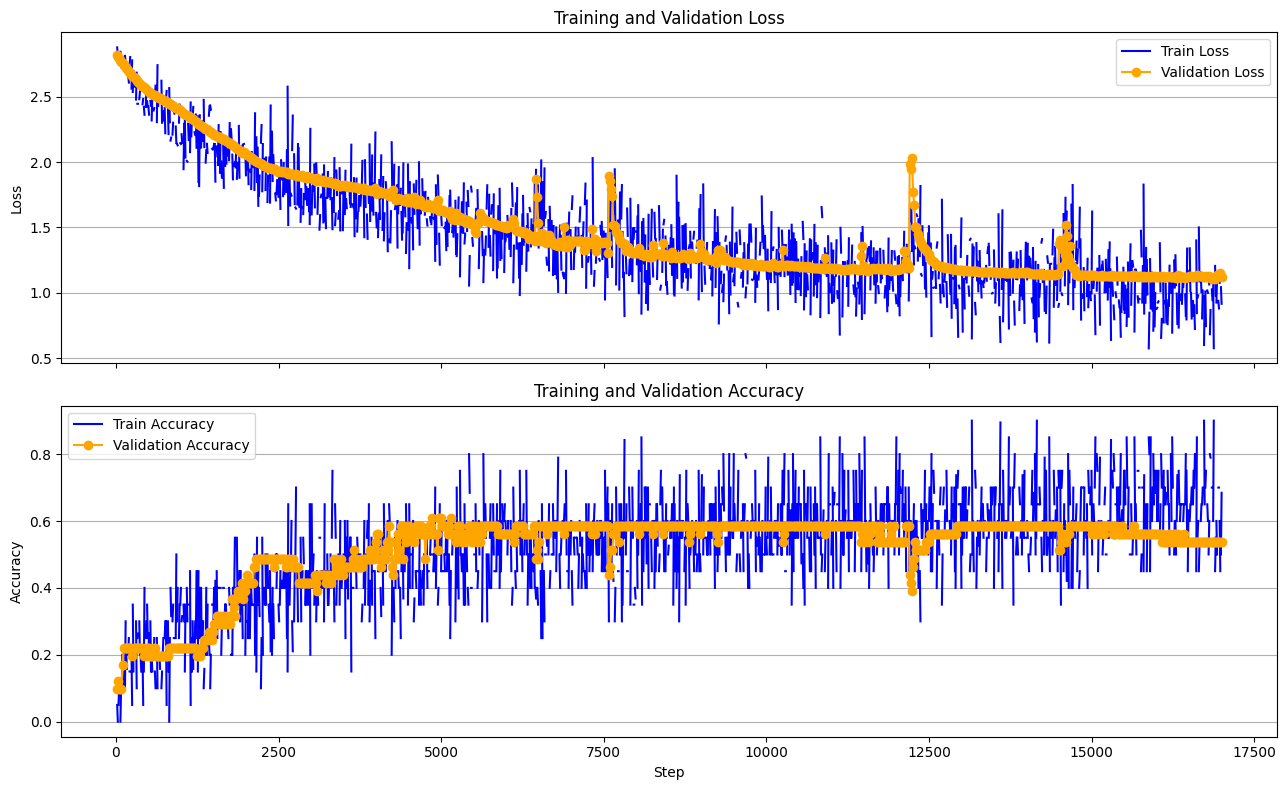

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("lightning_logs/version_0/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')


# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")


if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")

if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid

plt.tight_layout()
plt.show()


#### LSTM RNN

In [14]:
# Parametri modello
hidden_dim = 64
rnn_type = "LSTM"

model = RNNClassifier(
    input_dim=len(feature_columns),
    hidden_dim=hidden_dim,
    output_dim=len(label_encoder.classes_),
    rnn_type=rnn_type,
    lr=1e-4,
    dropout=0.2,
    weight_decay=1e-5
)

In [15]:
# Training setup
MAX_EPOCHS = 1000

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=MAX_EPOCHS // 10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[early_stop_callback],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    log_every_n_steps=10
)

# Addestramento
trainer.fit(model, train_loader, val_loader)

# Salvataggio modello
output_name = f"RNN_{rnn_type}_h{hidden_dim}_{now_date()}.ckpt"
trainer.save_checkpoint(os.path.join(model_output_path, output_name))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | rnn     | LSTM             | 21.0 K | train
1 | dropout | Dropout          | 0      | train
2 | fc      | Linear           | 1.1 K  | train
3 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
22.1 K    Trainable params
0         Non-trainable params
22.1 K    Total params
0.088     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 286: 100%|██████████| 17/17 [00:19<00:00,  0.88it/s, v_num=2, train_loss=1.730, train_acc=0.526, val_loss=1.970, val_acc=0.268]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 17/17 [00:07<00:00,  2.26it/s]

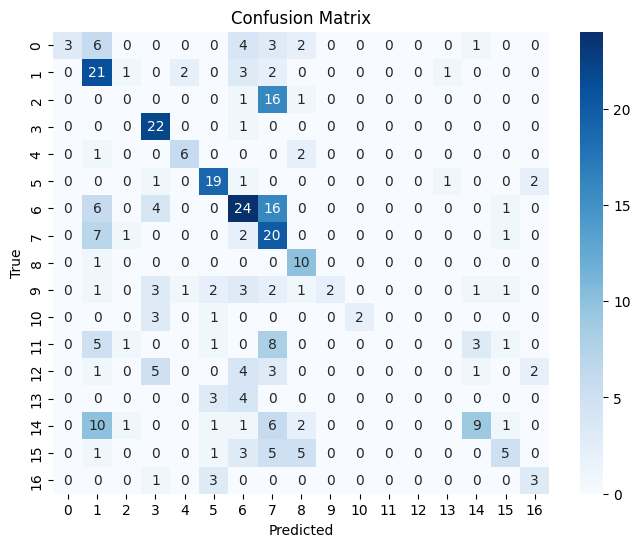

Testing DataLoader 0: 100%|██████████| 17/17 [00:09<00:00,  1.84it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     final_test_acc         0.43067845702171326
        test_acc            0.43067845702171326
        test_loss           1.7291290760040283
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]

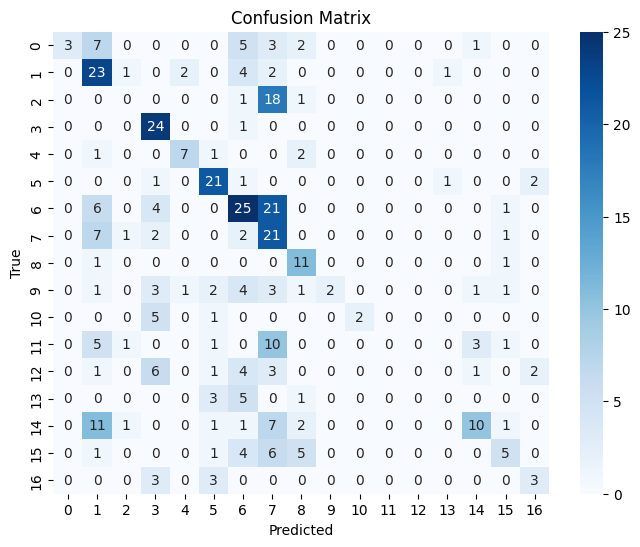

Testing DataLoader 0: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\miche\OneDrive\Desktop\tesi\repo-tesi\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     final_test_acc         0.4131578803062439
        test_acc            0.26829269528388977
        test_loss           1.9724621772766113
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]

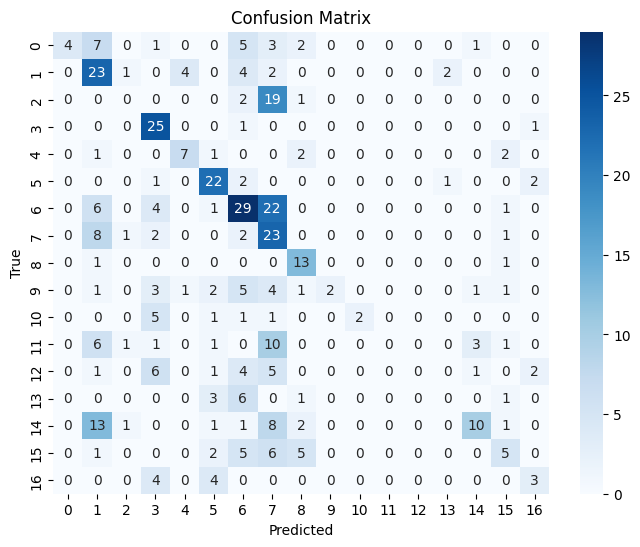

Testing DataLoader 0: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     final_test_acc         0.39904987812042236
        test_acc            0.26829269528388977
        test_loss            2.309114694595337
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.309114694595337,
  'test_acc': 0.26829269528388977,
  'final_test_acc': 0.39904987812042236}]

In [16]:
# Load the model for testing (from checkpoint)
model = RNNClassifier.load_from_checkpoint(os.path.join(model_output_path, output_name))
model.eval()
trainer.test(model, train_loader)
trainer.test(model, val_loader)
trainer.test(model, test_loader)

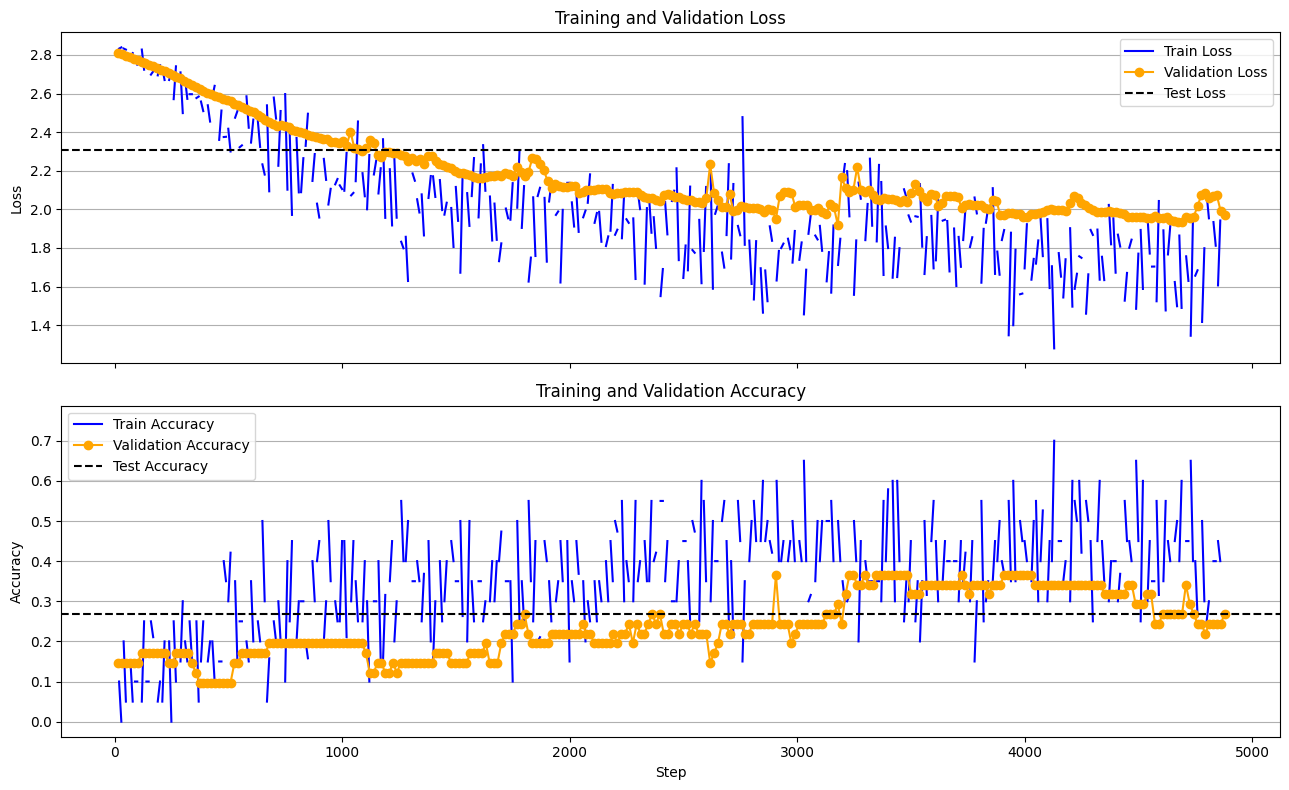

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("lightning_logs/version_2/metrics.csv")

# Convert columns to numeric safely
df["val_loss"] = pd.to_numeric(df["val_loss"], errors='coerce')
df["val_acc"] = pd.to_numeric(df["val_acc"], errors='coerce')
df["train_loss"] = pd.to_numeric(df["train_loss"], errors='coerce')
df["train_acc"] = pd.to_numeric(df["train_acc"], errors='coerce')


# Optional test metrics
test_loss = df["test_loss"].dropna().iloc[-1] if "test_loss" in df.columns else None
test_acc = df["test_acc"].dropna().iloc[-1] if "test_acc" in df.columns else None

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

# Plot losses
ax1.plot(df["step"], df["train_loss"], label="Train Loss", color="blue")
ax1.plot(df["step"][df["val_loss"].notna()], df["val_loss"].dropna(), label="Validation Loss", color="orange", marker="o")


if test_loss is not None:
    ax1.axhline(y=test_loss, color='black', linestyle='--', label="Test Loss")

ax1.set_ylabel("Loss")
ax1.set_title("Training and Validation Loss")
ax1.legend()
ax1.grid(axis='y')  # Only horizontal grid

# Plot accuracy
ax2.plot(df["step"], df["train_acc"], label="Train Accuracy", color="blue")
ax2.plot(df["step"][df["val_acc"].notna()], df["val_acc"].dropna(), label="Validation Accuracy", color="orange", marker="o")


if test_acc is not None:
    ax2.axhline(y=test_acc, color='black', linestyle='--', label="Test Accuracy")

ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Training and Validation Accuracy")
ax2.legend()
ax2.grid(axis='y')  # Only horizontal grid


plt.tight_layout()
plt.show()
